In [ ]:
import sys
import re
import os
import json
import pandas as pd
import numpy as np
#import scrapbook as sb
from sklearn.metrics import classification_report, accuracy_score, f1_score
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
df_train = pd.read_csv('df_train.csv')
print(df_train.shape)

(128000, 3)


In [ ]:
df_test = pd.read_csv('df_test.csv')
df_test.shape

(32000, 3)

In [ ]:
X_train = df_train['question_text']
X_test = df_test['question_text']

In [ ]:
y_train = df_train.target
y_test = df_test.target

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import sequence,text
from keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Lambda, Dense

In [ ]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 256
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True, 
                                   name='elmo_module')
        sess = tf.compat.v1.Session()
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(tf.compat.v1.tables_initializer())
        tf.compat.v1.keras.backend.set_session(sess)
        self.elmo = elmo_model
        #self._trainable_weights += trainable_variables(
        #            scope="^elmo_module/.*")
        
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                           as_dict=True,
                           signature='default',
                           )['elmo']
        print(result)
        return result

    # def compute_mask(self, inputs, mask=None):
    #   return K.not_equal(inputs, '__PAD__')

    def compute_output_shape(self, input_shape):
        return input_shape[0], 80, self.dimensions

In [ ]:
def build_model():
    input1 = Input(shape=(1,), dtype=tf.string)
    model = ElmoEmbeddingLayer(name='ElmoEmbeddingLayer')(input1)
    model = Bidirectional(LSTM(units=128,activation="tanh", recurrent_activation = "sigmoid",use_bias = True, recurrent_dropout=0.0, return_sequences=True))(model)
    model = Bidirectional(LSTM(units=128,activation="tanh", recurrent_activation = "sigmoid",unroll = False, recurrent_dropout=0.0,return_sequences=True))(model)
    model = Bidirectional(LSTM(units=128,activation="tanh", recurrent_activation = "sigmoid",unroll = False, recurrent_dropout=0.0,return_sequences=True))(model)
    model = GlobalMaxPooling1D()(model)
    model = Dense(16,activation='relu')(model)
    model = Dropout(0.1)(model)
    out =   Dense(1,activation='sigmoid')(model)
    model = Model(input1, out)
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    model.summary()
    return model

In [ ]:

model_elmo = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("ElmoEmbeddingLayer_11/elmo_module_11_apply_default/aggregation/mul_3:0", shape=(None, None, 1024), dtype=float32)


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
ElmoEmbeddingLayer (ElmoEmbe (None, None, 1024)        0         
_________________________________________________________________
bidirectional_30 (Bidirectio (None, None, 256)         1180672   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, None, 256)         394240    
_________________________________________________________________
bidirectional_32 (Bidirectio (None, None, 256)         394240    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

##### As the eager execution is disabled the cuda cannot be used !

In [ ]:
model_elmo.fit(X_train,y_train,epochs = 3,batch_size = 16, verbose = 1)

Train on 128000 samples
Epoch 1/3
128000/128000 [==============================] - 1957s 15ms/sample - loss: 0.2716 - accuracy: 0.8960
Epoch 2/3
128000/128000 [==============================] - 1955s 15ms/sample - loss: 0.2315 - accuracy: 0.9133
Epoch 3/3
128000/128000 [==============================] - 1960s 15ms/sample - loss: 0.2054 - accuracy: 0.9246


In [ ]:
preds = model_elmo.predict(X_test,batch_size=16,verbose=1)

In [ ]:
def line_search_f1_score(y_score, y_test):
    max_f1_score = 0
    opt_threshold = 0
    for threshold in [i*0.01 for i in range(100)]:
        y_preds = y_score > threshold
        score = f1_score(y_preds, y_test)
        if max_f1_score < score:
            max_f1_score = score
            opt_threshold = threshold
    return max_f1_score, opt_threshold

In [ ]:
max_f1_score, threshold = line_search_f1_score(preds, y_test)

In [ ]:
print(max_f1_score,threshold)

0.9112925419686267 0.44


In [ ]:
predictions = [1 if x>0.44 else 0 for x in preds]

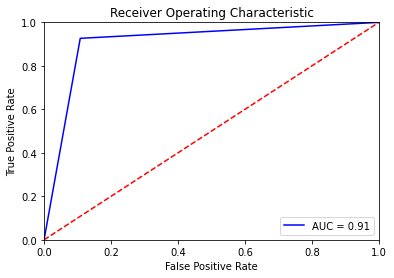

In [ ]:
import sklearn.metrics as metrics
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

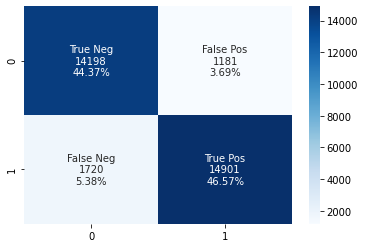

In [ ]:
cf_matrix = confusion_matrix(predictions, y_test)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
clf_report = classification_report(y_test,
                                   predictions,
                                   labels=[0,1],
                                   output_dict=True)

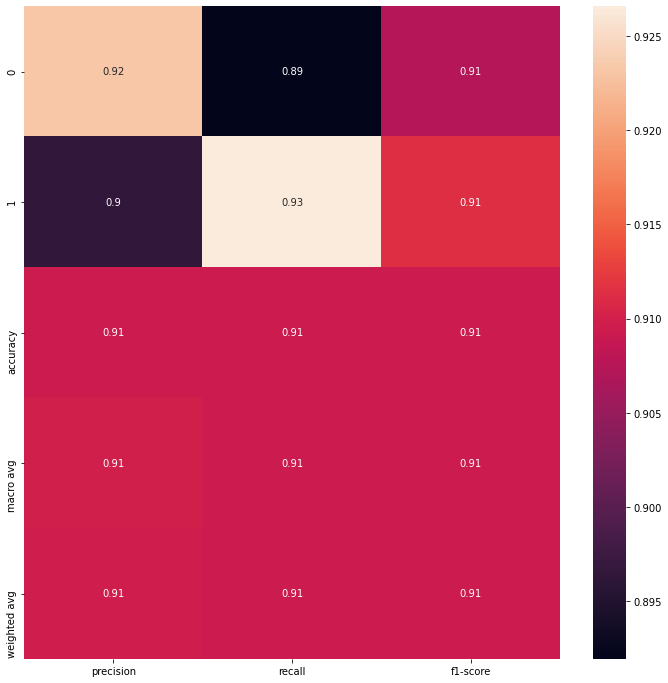

In [ ]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,ax=ax,square = False)

In [ ]:
print(accuracy_score(predictions,y_test))

0.90934375
